In [1]:
import qctoolkit as qtk
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import os

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# load data

In [2]:
data_dir = 'data'
mols = []
for h5 in sorted(glob(os.path.join(data_dir, 'H2*.h5'))):
    mols.append(qtk.QMInp(h5, electron_repulsion=False))

## basic matrix operations: segmentation and concatenation

In [3]:
def segment(matrix):
    """segment NxN matrix into N(N-1)/2 2x2 submatrices"""
    out = []
    for i in range(len(matrix) - 1):
        for j in range(i+1, len(matrix)):
            subm = [
                [matrix[i,i], matrix[i,j]],
                [matrix[j,i], matrix[j,j]]
            ]
            out.append(subm)
    return np.stack(out)

def ud_split(matrix, diag='upper'):
    """split matrix into symmetrized upper, lower triangular part, and diagonal
    
    kinetic, overlap, diag = ud_split(concat(kin))
    N = len(diag)
    
    overlap[(range(N), range(N))] = 1
    kinetic[(range(N), range(N))] = diag
    """
    N = len(matrix)
    U = np.zeros([N, N])
    D = np.zeros([N, N])
    uind = np.triu_indices(N, 1)
    U[uind] = matrix[uind]
    D[uind] = (matrix.T)[uind]
    U = U + U.T
    D = D + D.T
    return U, D, np.diag(matrix)

def concat(segment, merged=True):
    """reconstruct NxN matrix from N(N-1)/2 submatrices"""
    N = int(0.5 * (1 + np.sqrt(1 + 8 * len(segment))))
    out = np.zeros([N, N])
    itr = 0
    for i in range(N - 1):
        for j in range(i+1, N): 
            subm = segment[itr]            
            
            out[i, i] = subm[0, 0]
            out[i, j] = subm[0, 1]
            out[j, i] = subm[1, 0]
            out[j, j] = subm[1, 1]
            
            itr += 1
    if not merged:
        return out
    else:
        U, D, d = ud_split(out)
        U[(range(N), range(N))] = d
        D[(range(N), range(N))] = 1.
        return U, D

def merge(kin, olp):
    """merger two 2x2 symmetric matrices, lower(kin) = lower(olp)"""
    kin_olp = kin.copy()
    kin_olp[:,1,0] = olp[:,1, 0]
    return kin_olp

## test case

In [4]:
olp = segment(mols[0].olp)
kino = merge(segment(mols[0].kin), olp)
vo_ext = merge(segment(mols[0].v_ext), olp)

In [5]:
kin, olp_new = concat(kino)

In [6]:
kin - mols[0].kin

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Construct input tensor

In [7]:
tensor_data = []
for m in mols:
    olp = segment(mols[0].olp)
    ko = merge(segment(mols[0].kin), olp)
    vo = merge(segment(mols[0].v_ext), olp)
    # tensorflow convolutional layer expects 4D array
    tensor_data.append(np.concatenate([ko, vo]))
tensor_data = np.swapaxes(np.asarray(tensor_data), 1, -1)

In [8]:
energies = [m.Et for m in mols]

In [9]:
# number of molecule, number of interactions, number of basis function combinations, 2, 2
tensor_data.shape

(850, 2, 2, 12)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(tensor_data, energies, test_size=0.33, random_state=42)
y_train = np.reshape(y_train, (len(y_train), -1))
y_test = np.reshape(y_test, (len(y_test), -1))

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((569, 2, 2, 12), (281, 2, 2, 12), (569, 1), (281, 1))

# Fully convolutional test

In [23]:
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_1d, conv_2d, conv_2d_transpose
from tflearn.layers.core import input_data, dropout, fully_connected, flatten
from tflearn.layers.estimator import regression

In [39]:
# reset everything for fresh start
tf.reset_default_graph()

# FCN type approach
net = input_data(shape=[None, 2, 2, 12], name='input')
net = conv_2d(net, 32, 2, activation='relu')
net = conv_2d_transpose(net, 12, 2, output_shape=[2, 2, 12], activation='relu')
net = flatten(net)
# net = fully_connected(net, 50, activation='relu')
# net = dropout(net, 0.8)
net = fully_connected(net, 50, activation='relu')
net = dropout(net, 0.8)
net = fully_connected(net, 1, activation='linear')

#

convnet = regression(net, optimizer='adam', learning_rate=0.0005, loss='mean_square' , name='targets')

In [40]:
model = tflearn.DNN(convnet, tensorboard_dir="logs")

In [41]:
model.fit(
    {'input': X_train}, 
    {'targets': y_train}, 
    n_epoch=100, 
    validation_set=({'input': X_test}, {'targets': y_test}), 
    #show_metric=True, 
    run_id='CCN_test'
)

Training Step: 899  | total loss: 0.02017 | time: 0.053s
| Adam | epoch: 100 | loss: 0.02017 -- iter: 512/569
Training Step: 900  | total loss: 0.01971 | time: 1.064s
| Adam | epoch: 100 | loss: 0.01971 | val_loss: 0.00804 -- iter: 569/569
--


In [17]:
model.save('models/test_model')

INFO:tensorflow:/home/samio/Works/postPhD/Basel/projects/02_QM_AI/05_FCN/models/test_model is not in all_model_checkpoint_paths. Manually adding it.


In [18]:
model.load('models/test_model')

INFO:tensorflow:Restoring parameters from /home/samio/Works/postPhD/Basel/projects/02_QM_AI/05_FCN/models/test_model


In [42]:
#y_prd = model2.predict(np.random.random(X_test.shape))
y_prd = model.predict(X_test)

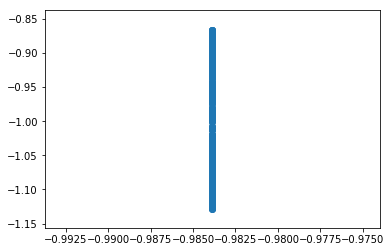

In [43]:
plt.scatter(y_prd, y_test)

In [44]:
((y_prd - y_test) ** 2).mean()

0.00803713926733027

In [50]:
model.trainer?